# LLM

Generate text embeddings from different transformer models.

Combine embeddings with structured numeric/categorical features.

Train and evaluate supervised ML models using both types of features.

Compare different embedding models and interpret their impact on performance.

## Mount Drive

In [1]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Libraries

In [2]:
%pip install "sentence-transformers==3.*" scikit-learn pandas numpy

import re, numpy as np, pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.2
    Uninstalling sentence-transformers-5.1.2:
      Successfully uninstalled sentence-transformers-5.1.2


In [3]:
# -------------------------------
# 🔒 FULL REPRODUCIBILITY SETTINGS
# -------------------------------
import os, random
import numpy as np
import torch

SEED = 42

# Python built-in randomness
random.seed(SEED)

# NumPy randomness
np.random.seed(SEED)

# Torch (used inside SentenceTransformer models)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensures deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# scikit-learn uses NumPy seed internally
os.environ["PYTHONHASHSEED"] = str(SEED)


## Load Data

In [4]:
# 1) Load a built-in dataset (binary subset for speed)
cats = ["sci.space", "rec.autos"]
ds = fetch_20newsgroups(subset="train", categories=cats, remove=("headers","footers","quotes"))
X_text = pd.Series(ds.data)
y = pd.Series(ds.target)  # 0/1 labels

In [5]:
print("Number of documents:", len(X_text))
print("Classes:", y.unique())
print("Class names:", ds.target_names)


Number of documents: 1187
Classes: [1 0]
Class names: ['rec.autos', 'sci.space']


In [6]:
X_text.head(3).tolist()


["Well thank you dennis for your as usual highly detailed and informative \nposting.   \n\nThe question i have about the proton, is  could it be  handled at\none of KSC's spare pads, without major  malfunction,  or could it be\nhandled at kourou  or Vandenberg?   \n\nNow if it uses storables,  then  how long would it take for the russians\nto equip something at cape york?\n\nIf  Proton were launched from a western site,  how would it compare to the\nT4/centaur?   As i see it, it should lift  very close to the T4.",
 "\n\nPerhaps a nice used '88 Pontiac Fiero GT?  2.8 liters.\n\nDoes anyone know if the motor mounts for the 2.8 and the twin-dual-cam 3.4\nliter match?  The 3.4 is supposedly derived from the pushrod 3.1, which was\na punched out 2.8 liter.  Should be a drop-in replacement, eh?  205 horses in\na mid-engine the size of a Fiero?\n\nLarry Smith (smith@ctron.com)  No, I don't speak for Cabletron.  Need you ask?",
 "I bought a car with a defunct engine, to use for parts\nfor my 

count     1187.000000
mean       991.835720
std       2508.509621
min          0.000000
25%        224.500000
50%        441.000000
75%        858.000000
max      39971.000000
dtype: float64


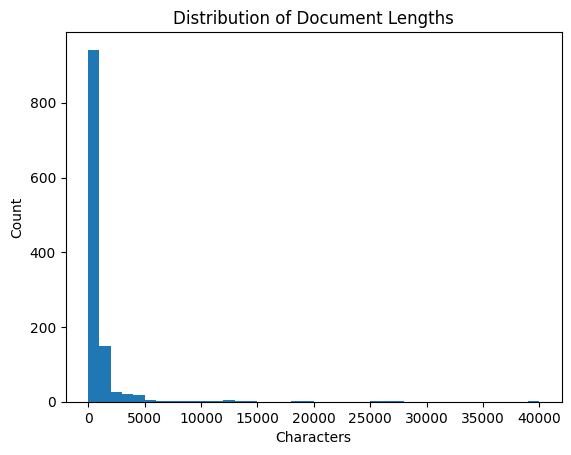

In [7]:
import matplotlib.pyplot as plt
doc_lengths = X_text.str.len()
print(doc_lengths.describe())


plt.hist(doc_lengths, bins=40)
plt.title("Distribution of Document Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


In [8]:
(X_text.str.strip() == "").sum()


np.int64(48)

## Create simple "structured" features from the text itself

In [9]:
# 2) Create simple "structured" features from the text itself
def text_struct_feats(s: str):
    s = s or ""
    n_chars = len(s)
    words = re.findall(r"\b\w+\b", s.lower())
    n_words = len(words)
    avg_word_len = (sum(len(w) for w in words) / (n_words or 1))
    punc = re.findall(r"[^\w\s]", s)
    punc_ratio = len(punc) / (n_chars or 1)
    digits = re.findall(r"\d", s)
    digit_ratio = len(digits) / (n_chars or 1)
    caps_ratio = sum(1 for c in s if c.isupper()) / (n_chars or 1)
    return pd.Series({
        "n_chars": n_chars,
        "n_words": n_words,
        "avg_word_len": avg_word_len,
        "punc_ratio": punc_ratio,
        "digit_ratio": digit_ratio,
        "caps_ratio": caps_ratio,
    })

X_struct = X_text.apply(text_struct_feats)
# Optional categorical feature: which category name (here we only have the label; skip or add dummy)
NUMERIC_COLS = X_struct.columns.tolist()
CAT_COLS = []  # none here; could add bins or other categorical transforms

## Create a function that runs Steps 3–6 for ONE embedding model

### 1. Generate text embeddings
### 2. Preprocess structured features and fuse with embeddings
### 3. Train/test split
### 4. Train two models and evaluate

In [11]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



CUDA available: True
GPU name: NVIDIA L4
Using device: cuda


In [18]:
import time
from sklearn.metrics import confusion_matrix

def evaluate_embedding_model(embed_model, X_text, X_struct, y, device="cpu"):
    """
    Runs Steps 3–6:
    - Load embedding model
    - Generate embeddings (timed)
    - Combine with structured features
    - Train LogReg & RandomForest
    - Return metrics + confusion matrices + timing
    """
    print(f"\n===== Running model: {embed_model} =====")

    # --------------------------
    # 1) Load model
    # --------------------------
    embedder = SentenceTransformer(embed_model, device=device)

    # --------------------------
    # 2) Generate embeddings (TIMED)
    # --------------------------
    start = time.time()
    E = embedder.encode(
        X_text.fillna("").tolist(),
        batch_size=64,
        convert_to_numpy=True,
        device=device,
        show_progress_bar=False
    )
    embed_time = time.time() - start
    print(f"Embedding time: {embed_time:.2f} sec")

    # --------------------------
    # 3) Preprocess structured features
    # --------------------------
    NUMERIC_COLS = X_struct.columns.tolist()
    CAT_COLS = []

    preprocess = ColumnTransformer([
        ("num", StandardScaler(), NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS)
    ])

    X_struct_proc = preprocess.fit_transform(X_struct)
    X = np.hstack([X_struct_proc, E])

    # --------------------------
    # 4) Train/test split
    # --------------------------
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y.values, test_size=0.25, random_state=42, stratify=y
    )

    # --------------------------
    # 5) Train models + store results
    # --------------------------
    results = {}
    models = {
        "LogReg": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42)
    }

    for name, clf in models.items():
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)
        proba = clf.predict_proba(X_te)[:, 1]

        cm = confusion_matrix(y_te, pred)

        results[name] = {
            "accuracy": accuracy_score(y_te, pred),
            "f1": f1_score(y_te, pred),
            "roc_auc": roc_auc_score(y_te, proba),
            "conf_matrix": cm,
            "embed_time": embed_time
        }

    return results


## Run Multiple Embedding Models

In [19]:
models_to_test = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "intfloat/e5-small-v2",
    "BAAI/bge-small-en-v1.5"
]

all_results = {}

device = "cuda" if torch.cuda.is_available() else "cpu"

for m in models_to_test:
    all_results[m] = evaluate_embedding_model(
        m, X_text, X_struct, y, device=device
    )



===== Running model: sentence-transformers/all-MiniLM-L6-v2 =====
Embedding time: 1.08 sec

===== Running model: intfloat/e5-small-v2 =====
Embedding time: 2.60 sec

===== Running model: BAAI/bge-small-en-v1.5 =====
Embedding time: 2.56 sec


## Create a Comparison Table (Accuracy, F1, AUC, Time)

In [20]:
rows = []

for embed_model, scores in all_results.items():
    for clf_name, metrics in scores.items():
        rows.append([
            embed_model, clf_name,
            metrics["accuracy"],
            metrics["f1"],
            metrics["roc_auc"],
            metrics["embed_time"]
        ])

df_results = pd.DataFrame(rows, columns=[
    "Embedding Model", "Classifier", "Accuracy", "F1", "ROC_AUC", "Embed_Time"
])

print(df_results)


                          Embedding Model    Classifier  Accuracy        F1  \
0  sentence-transformers/all-MiniLM-L6-v2        LogReg  0.939394  0.938776   
1  sentence-transformers/all-MiniLM-L6-v2  RandomForest  0.949495  0.948805   
2                    intfloat/e5-small-v2        LogReg  0.952862  0.952703   
3                    intfloat/e5-small-v2  RandomForest  0.962963  0.962963   
4                  BAAI/bge-small-en-v1.5        LogReg  0.952862  0.952381   
5                  BAAI/bge-small-en-v1.5  RandomForest  0.949495  0.949495   

    ROC_AUC  Embed_Time  
0  0.991225    1.075326  
1  0.979276    1.075326  
2  0.984287    2.595498  
3  0.980410    2.595498  
4  0.990454    2.564395  
5  0.977372    2.564395  


### Interpreting the comparative chart

Across all models, performance is consistently strong, with accuracy and F1 ranging from 0.94 to 0.96. The **best overall results come from E5-small** with **RandomForest**, achieving the **highest accuracy and F1 (0.963, 0.963)**. MiniLM is the fastest to compute embeddings (1.07 sec) but slightly weaker in performance, while E5-small and BGE-small take longer (2.6 sec) yet deliver improved classification quality, especially for E5-small.

## Plot Confusion Matrices

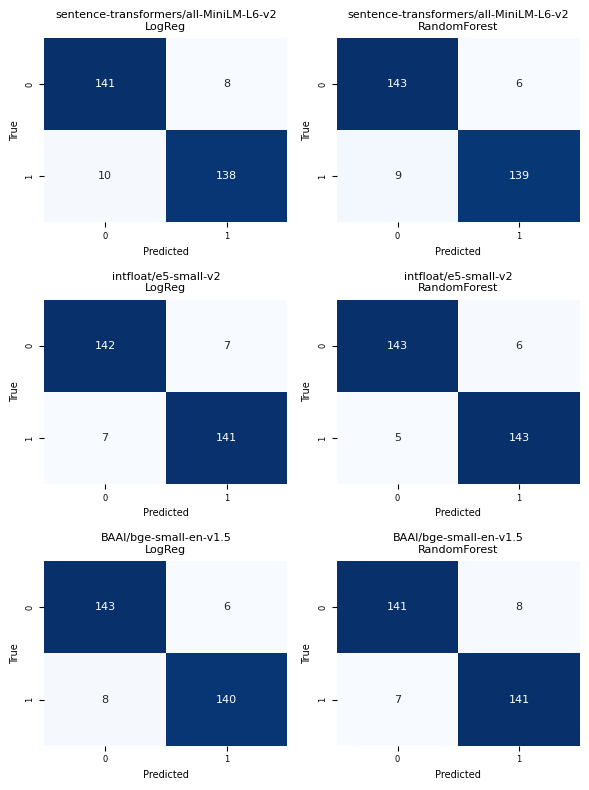

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(6, 8))

for row_idx, (embed_model, scores) in enumerate(all_results.items()):
    for col_idx, (clf_name, metrics) in enumerate(scores.items()):
        cm = metrics["conf_matrix"]
        ax = axes[row_idx, col_idx]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                    annot_kws={"size": 8})  # smaller font
        ax.set_title(f"{embed_model}\n{clf_name}", fontsize=8)
        ax.set_xlabel("Predicted", fontsize=7)
        ax.set_ylabel("True", fontsize=7)
        ax.tick_params(axis='both', labelsize=6)

plt.tight_layout()
plt.show()




### Confusion Matrices Summary

Across all embedding models and classifiers, the confusion matrices show **very strong and balanced performance**, with **low misclassification rates** for both classes. **E5-small combined with RandomForest performs the best**, producing the fewest false positives and false negatives. MiniLM and BGE-small also perform consistently well, with only slight variations in error counts, confirming that all three embedding models capture the semantic differences between classes effectively.

## Heatmap Comparing All Models

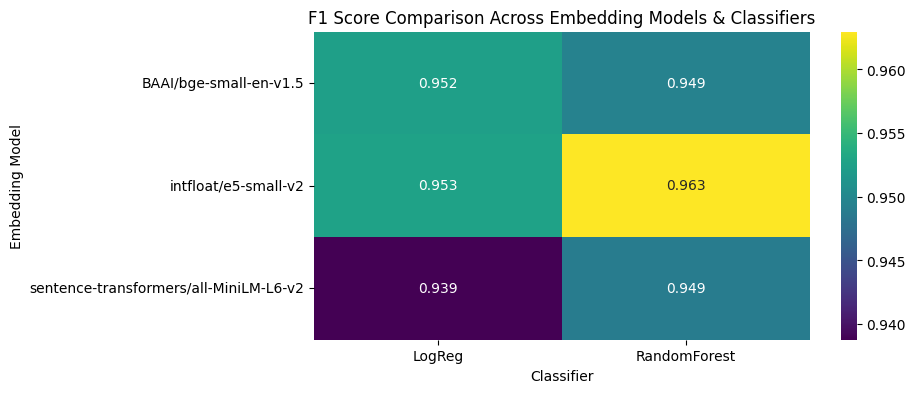

In [23]:
pivot = df_results.pivot(
    index="Embedding Model",
    columns="Classifier",
    values="F1"
)
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("F1 Score Comparison Across Embedding Models & Classifiers")
plt.show()



### Heatmap summary


The F1 score heatmap shows that **E5-small paired with RandomForest delivers the highest overall performance (F1 = 0.963)**, outperforming all other combinations. MiniLM performs the weakest with Logistic Regression, while BGE-small provides consistently strong results across both classifiers. Overall, newer embedding models (E5 and BGE) clearly improve downstream classification compared to the MiniLM baseline.

# Over All winner : E5-small paired with Random Forest

In [29]:
!jupyter nbconvert /content/drive/MyDrive/hu_sem3_715/week12.ipynb --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/hu_sem3_715/week12.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 452730 bytes to /content/drive/MyDrive/hu_sem3_715/week12.html
